In [117]:
import sys
print (sys.version)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
from itertools import chain
import math
%matplotlib inline

3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]



# Project WP1-2
### code 2: Display, and group ports
<span style='font-family:"Times New Roman"'> <span styel=''> 
This code is used to group terminals by given radius (e.g., 100 nm), and to add extra features "Port" and "Region".
The working datset in this sheet is "PortList.csv";
### Basic steps: 
    a) Load data;
    b) Calculate distance, and group terminal, individually;
    c) Assign a common name for each terminal group;
    d) Update "portInfor.csv" file with grouped ports, and further remove duplicates;
    e) Save dataset;

###  Step a) : Load data, sort data, and display ports info in geographic map

In [118]:
df_ports=pd.read_csv("C:/posDoc-SDU-Denmark/SDU_research/shippingLabwp1/portsInfo.csv")
df_ports.sort_values(axis=0,by=["number of call all"],ascending=False,inplace=True)  # descend order !

print (df_ports.info())
print ("----------------------------------------------------------------------------------------------------------------------")
print ("The statistic information of portsInfor:\n")
print (df_ports.describe().T)
print ("----------------------------------------------------------------------------------------------------------------------")
print ("The shape of portsInfo file:",df_ports.shape)
print ("----------------------------------------------------------------------------------------------------------------------")
print ("The features names of portsInfor:\n",df_ports.columns.to_list())
print ("----------------------------------------------------------------------------------------------------------------------")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3288 entries, 0 to 3287
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Terminal              3288 non-null   object 
 1   Country               3288 non-null   object 
 2   Lat                   3288 non-null   float64
 3   Lon                   3288 non-null   float64
 4   number of call start  3288 non-null   float64
 5   number of call end    3288 non-null   float64
 6   number of call all    3288 non-null   float64
dtypes: float64(5), object(2)
memory usage: 205.5+ KB
None
----------------------------------------------------------------------------------------------------------------------
The statistic information of portsInfor:

                       count        mean         std        min        25%  \
Lat                   3288.0   22.971758   25.946251  -53.27303   6.957058   
Lon                   3288.0   21.931035   78.278837 -171.7

In [119]:
df_ports.head()

,Terminal,Country,Lat,Lon,number of call start,number of call end,number of call all
0,Singapore,Singapore,1.20470,103.67232,7403.0,7365.0,14768.0
1,PTP Terminal,Russia,60.32058,28.72898,3785.0,3781.0,7566.0
2,Novorossiysk,Russia,44.72680,37.78154,3762.0,3762.0,7524.0
3,Yeosu,South Korea,34.71473,127.81125,3531.0,3547.0,7078.0
4,Houston,United States of America,29.23550,-94.62350,3371.0,3375.0,6746.0


### display ports data

In [120]:
def draw_map(m, scale=0.5):
    """
    plot backgroud map
    m: Basemap object
    scale: plot scale
    
    return: plot a backgroud map
    """
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    #m.bluemarble(scale=scale)  #Project NASA's blue marble image onto the map
    #m.drawcoastlines()
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

def check_valsCount(df):
    """
    Check values counts in given dataframe
    return: counts of each column in given dataframe
    """
    cols=df.columns
    counts_all=[]
    for col in cols:
        counts=df.loc[:,col].value_counts()
        counts_all.append(counts)
        print (counts)
        print ('\n')
    return counts_all

Kulevi Oil Terminal                1
Barra dos Coqueiros                1
Emden                              1
Dinasa Terminal                    1
Harnosand                          1
                                  ..
Muntok                             1
Oiltanking Terneuzen               1
Everport Terminal Los Angeles      1
Jiangsu Litian P and C Terminal    1
Belfast                            1
Name: Terminal, Length: 3288, dtype: int64


----------------------------------------------------------------------------------------------------------------------
No duplicate terminals any more !
----------------------------------------------------------------------------------------------------------------------
The respective minimum and maximum latitude and longitude coordiates of ports are: (-53.27303000000001, 76.55333, -171.7624, 179.36674)


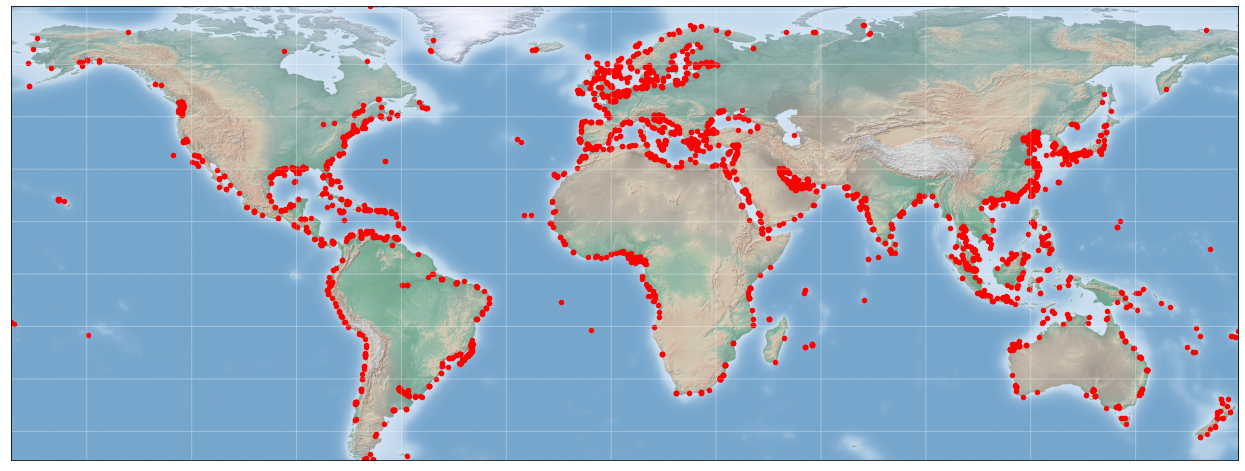

In [121]:
# Check terminal duplicates
df_terminal=pd.DataFrame(df_ports.Terminal)
counts_all=check_valsCount(df_terminal)
print ("----------------------------------------------------------------------------------------------------------------------")
print ("No duplicate terminals any more !")
print ("----------------------------------------------------------------------------------------------------------------------")

# visulize original ports 
bbox=(df_ports.Lat.min(),df_ports.Lat.max(),df_ports.Lon.min(),df_ports.Lon.max())                                                        
print ("The respective minimum and maximum latitude and longitude coordiates of ports are:",bbox)

fig,ax=plt.subplots(figsize=(22,14))
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=bbox[0], urcrnrlat=bbox[1],
            llcrnrlon=bbox[2], urcrnrlon=bbox[3])
ax.scatter(df_ports.Lon,df_ports.Lat,zorder=1, alpha= 1, c='r', s=20)
draw_map(m)

ax.set_xlim(bbox[2],bbox[3]);
ax.set_ylim(bbox[0],bbox[1]);
fig.savefig("C:/posDoc-SDU-Denmark/SDU_research/shippingLabwp1/portsOriginal_1.png",dpi=400)

### Step b):  Calculate location distance, and group terminals

In [122]:
def dist(lat1,lat2,lon1,lon2):
    """
    compute the great-circle distance between two locations on earth.
    lat1,lon1: location information of location 1; in degrees
    lat2,lon2: location information of location 2; in degrees
    
    return: numeric; distance, in km
    """ 
    from math import radians, cos, sin, asin,sqrt
    R=6371  # km
    
    #  turn to radias
    lon1=radians(lon1) 
    lon2=radians(lon2)
    lat1=radians(lat1)
    lat2=radians(lat2)
    
    # Haversine formula
    dlon=lon2-lon1
    dlat=lat2-lat1
    a=sin(dlat/2)**2+cos(lat1)*cos(lat2)*sin(dlon/2)**2
    
    c = 2 * asin(sqrt(a))
    d=R*c # km
    return d

def similar_terminal(df, ix1, lat1, lon1,dist_ref=100 * 1.852):
    """
    Given a location (ix1,lat1, lon1), compute the distance between this single location and all other locations in dataframe.
    Then, extract all the ids of similar terminals when dist is not larger than dist_ref.
    
    df:dataFrame
    ix1,lat1,lon1: index of each row, latitude, longitude
    dist_ref: reference distance,the default is 185.2km
    return:ids dict; terminals dict
    """
    similars_ids_single = {}
    similars_terminals_single = {}

    # remove the original location itself
    #df_update = df.drop([ix1], axis=0)

    # loop to find the suitable ids
    for ix2, lat2, lon2 in zip(df.index, df.Lat, df.Lon):
        dist_temp = dist(lat1, lat2, lon1, lon2)
        if dist_temp <= dist_ref:
            similars_ids_single.setdefault(ix1, []).append(ix2)
            similars_terminals_single.setdefault(df.loc[ix1, 'Terminal'], []).append(df.loc[ix2, 'Terminal'])

    if (similars_ids_single=={}) or (similars_terminals_single=={}):
        return "No",ix1,similars_ids_single, similars_terminals_single
    else:
        return "Yes",ix1,similars_ids_single, similars_terminals_single

def similar_terminals(df):
    """
    compute all similar terminals, given a dataframe
    Add them into a dictionary for further utilization.
    
    return: lists including all similar terminals for every terminal in given dataframe, and lists of terminals without similars
    """
    similars_ids_all = []
    similars_terminals_all = []
    noSimilars_terminals=[]


    for id1, lat1, lon1 in zip(df.index, df.Lat, df.Lon):
        flag,temp_ix,temp_id, temp_terminals = similar_terminal(df, id1, lat1, lon1)
        if flag=="No"or len(list(temp_terminals.values())[0])==1:
            noSimilars_terminals.append(temp_ix)
        else:  
            similars_ids_all.append(temp_id)
            similars_terminals_all.append(temp_terminals)

    return similars_ids_all, similars_terminals_all,noSimilars_terminals

def listToDict(list1):
    # swith a list to a dict
    # to dicts
    dicts={}
    for ix,elem in enumerate(list1):
        dicts.update(elem)
    return dicts

# # test case for dist() function
# lat1,lat2=53.32055555555556,53.31861111111111
# long1,long2=-1.7297222222222221,-1.6997222222222223
# d=dist(lat1,lat2,long1,long2)
# print (d)

In [123]:
# test case for similar_terminal()
print ("Test case for similar terminal()")
_,_,similars_ids_single,similars_terminals_single=similar_terminal(df_ports,1231,-52.81843,-68.16315)
print (df_ports[df_ports.Terminal=="Rio Cullen"])
print ("----------------------------------------------------------------------------------------------------------------------")
print ("the similar terminals ids as terminal 'Rio Cullen' id:",similars_ids_single)
print ("----------------------------------------------------------------------------------------------------------------------")
print ("the similar terminals as terminal 'Rio Cullen':",similars_terminals_single)

# compute all similar termilars in df_ports
similars_ids_all,similars_terminals_all,nosimilars_all=similar_terminals(df_ports)
print ("----------------------------------------------------------------------------------------------------------------------")
print ("The name of all similar terminals (first 1 item):\n",similars_terminals_all[:1])
print ("----------------------------------------------------------------------------------------------------------------------")
print ("the ids of all the similar terminals (first 1 item):\n",similars_ids_all[:1])
print ("----------------------------------------------------------------------------------------------------------------------")
print ("the ids of all the terminals without similars:\n",nosimilars_all)
print ("----------------------------------------------------------------------------------------------------------------------")
print ("the length of terminals with similars:",len(similars_ids_all))
print ("the length of terminals without similars:",len(nosimilars_all))

Test case for similar terminal()
        Terminal    Country       Lat       Lon  number of call start  \
1231  Rio Cullen  Argentina -52.81843 -68.16315                  57.0   

      number of call end  number of call all  
1231                56.0               113.0  
----------------------------------------------------------------------------------------------------------------------
the similar terminals ids as terminal 'Rio Cullen' id: {1231: [1231, 1556, 1687, 1897, 1934]}
----------------------------------------------------------------------------------------------------------------------
the similar terminals as terminal 'Rio Cullen': {'Rio Cullen': ['Rio Cullen', 'San Sebastian', 'Puerto Sara', 'Cabo Negro Gas Terminal', 'Punta Loyola']}
----------------------------------------------------------------------------------------------------------------------
The name of all similar terminals (first 1 item):
 [{'Singapore': ['Singapore', 'Oiltanking Singapore Terminal', 'Univers

### Step c): Group terminals and assign a common name for each group

In [124]:
def mainPortToFind(similars_all,similars_all_ids):
    """
    Find the main port, and the minor port among all the similar groups given a sorted list. 
    Due to search strategy, it is probably needed a second round of main port search.
    This stratgy causes some duplicates terminals with different "Main_port", which should be removed later
    
    similars_all: list,sorted, containing all terminals with their similarity
    similars_all_ids: list, sorted, containing all terminals' id with their similarity. It has a strict match with similars_all
    return: main port dict, minor port dict
    """
    
    # copy dict, in order to pop() on the copy dict
    similar_dict=listToDict(similars_all)
    similar_dictC=similar_dict.copy()
    similar_dict_ids=listToDict(similars_all_ids)
    similar_dictC_ids=similar_dict_ids.copy()
    
    # name, ids of terminals
    terminals_all=list(similar_dictC.keys()) #  all terminals with similars, sorted by "number of call all"
    terminals_all_ids=list(similar_dictC_ids.keys()) # ids of all similar'terminals
    leng=len(terminals_all)
    
    minor_terminals={}
    minor_terminals_ids={}
    flag="NoTerm"
    
    for mainPort in terminals_all:
        # remove overlapping terminals
        if mainPort  not in similar_dictC.keys():
            continue
        
        for terminal in similar_dictC[mainPort]:
            if terminal !=mainPort and terminal in similar_dictC.keys():
                pop_val=similar_dictC.pop(terminal,flag)

    for mainPort_id in terminals_all_ids:
        # remove overlapping terminals' ids
        if mainPort_id  not in similar_dictC_ids.keys():
            continue
        
        for terminal_id in similar_dictC_ids[mainPort_id]:
            if terminal_id !=mainPort_id and terminal_id in similar_dictC_ids.keys():
                pop_val_1=similar_dictC_ids.pop(terminal_id,flag)
                
    for key, value in similar_dict.items():
        if key not in similar_dictC.keys():
            minor_terminals.update({key:value})
            
    for key, value in similar_dict_ids.items():
        if key not in similar_dictC_ids.keys():
            minor_terminals_ids.update({key:value})
    
    return similar_dictC, minor_terminals,similar_dictC_ids,minor_terminals_ids


def findUnion(list1,list2):
    """
    find union of list1 and list2, as long as only element from list1 is also in list2
    list1,list2: list
    return: union list, or list1
    """
    
    if list1 == [] or list2== []:
        return 
    union=list1
    for elem in list1:
        if elem in list2:
            union.extend(list2)
        break
    return union


def findGroups_union(similar_List):
    """
    Too time consuming !!! not working!!!
    There are overlapping terminals in differet terminal groups.
    Find the lagest group containing all similar terminals.
    Note that, the input list should be in descending order (based on the number of calls)
    
    similar_List: list, containing all similar terminals.
    return: dict, containing similar terminals 
    """
    
    similar_Dict=listToDict(similar_List)
    similar_DictC=similar_Dict.copy()  
    
    terminals_all=list(similar_DictC.keys()) #  all terminals list, sorted by "number of call all"
    leng=len(terminals_all)
    
    clean_terminals={}
    
    for j in range(leng):
        
        mains=list(similar_List[j].keys())[0] # main terminal
        main_similars=list(similar_List[j].values())[0] # list, similar terminals from main terminal
        
        for terminal in main_similars:
            if terminal in similar_Dict.keys():
                main_similars.extend(list(similar_Dict.values())[0])
                main_similars=list(set(main_similars))
        clean_terminals.update({mains:main_similars})
        
    return clean_terminals

def groupCommon(df,portCommon="Rio Cullen",terminals_similar=[1231,1556, 1687, 1897, 1934],extra_col="Main_port",sortValue="number of call all"):
    """
    Group dataframe with given idx, and sort it in a descend way.
    sorted the dataframe by sortValue in a descend way, Add extra column 
    
    df: dataframe
    portCommon: string, terminal used as the common port name of a group of close terminals
    terminals_similar: list; all ids of similar terminals with portCommon,including portCommon itself. 
    sortValue: string, used for sorting of dataframe
    
    return:dataframe of a group of similar terminals
    """
    df_similar=df.loc[terminals_similar]
    df_similar.sort_values(axis=0,by=[sortValue],ascending=False,inplace=True)
    df_similar[extra_col]=portCommon
    
    return df_similar


In [185]:
similars_terminals_all11=listToDict(similars_terminals_all)
terminals_all22=len(list(similars_terminals_all11.keys()))
print (terminals_all22)

3194


In [161]:
main_ports,minor_ports,main_ports_id,minor_ports_id=mainPortToFind(similars_terminals_all,similars_ids_all)
print ("---------------------------------------------------------------------------------------------------------------------")
print ("Main ports length",len(main_ports))
print ("Main ports (one items presented):",list(main_ports.keys())[:10])
print ("---------------------------------------------------------------------------------------------------------------------")
print ("Main ports length",len(main_ports_id))
print ("Main ports ids (one items presented):",list(main_ports_id.keys())[:10])
print ("---------------------------------------------------------------------------------------------------------------------")

print ("Minor ports length",len(minor_ports))
print ("Minor ports (one item presented):",minor_ports['Auckland'])
print ("---------------------------------------------------------------------------------------------------------------------")
print ("Minor ports length",len(minor_ports_id))
print ("Minor ports ids (one item presented):",minor_ports_id[3287])

---------------------------------------------------------------------------------------------------------------------
Main ports length 419
Main ports (one items presented): ['Singapore', 'PTP Terminal', 'Novorossiysk', 'Yeosu', 'Houston', 'Dalian', 'Jubail', 'Khor Fakkan', 'Hong Kong', 'Sarroch']
---------------------------------------------------------------------------------------------------------------------
Main ports length 419
Main ports ids (one items presented): [0, 1, 2, 3, 4, 5, 6, 7, 8, 10]
---------------------------------------------------------------------------------------------------------------------
Minor ports length 2775
Minor ports (one item presented): ['Marsden Point Refinery', 'Tauranga', 'Marsden Point', 'Auckland Bulk Storage Terminal', 'New Zealand', 'Auckland']
---------------------------------------------------------------------------------------------------------------------
Minor ports length 2775
Minor ports ids (one item presented): [241, 761, 1717, 1

### Step d): Update "portInfor.csv" file with grouped ports, and further remove duplicates

In [126]:
df_ports.head()

,Terminal,Country,Lat,Lon,number of call start,number of call end,number of call all
0,Singapore,Singapore,1.20470,103.67232,7403.0,7365.0,14768.0
1,PTP Terminal,Russia,60.32058,28.72898,3785.0,3781.0,7566.0
2,Novorossiysk,Russia,44.72680,37.78154,3762.0,3762.0,7524.0
3,Yeosu,South Korea,34.71473,127.81125,3531.0,3547.0,7078.0
4,Houston,United States of America,29.23550,-94.62350,3371.0,3375.0,6746.0


In [127]:
main_singapore=groupCommon(df_ports,portCommon="Singapore",terminals_similar=similars_ids_all[0][0],sortValue="number of call all")
print (len(main_singapore))
print(main_ports["Singapore"])

#df_ports[df_ports.Terminal==main_ports["Singapore"]]

69
['Singapore', 'Oiltanking Singapore Terminal', 'Universal Oil Terminal', 'ExxonMobil Terminal', 'Vopak Sebarok Terminal', 'Tanjung Bin', 'Vopak Banyan Terminal', 'Pulau Busing Terminal', 'Horizon Singapore Terminal', 'TLP Liquid Cargo Terminal', 'Pulau Bukom Refinery', 'Pengerang Deepwater Terminal', 'SRC Terminal', 'Pasir Gudang Edible Oil Terminal', 'Tanjung Pelepas', 'Seraya Power Station Terminal', 'Pasir Gudang Non-Edible Liquid Terminal', 'Oiltanking Helios Terminal', 'Vopak Sakra Terminal', 'Vopak Penjuru Terminal', 'Tanjung Uban', 'ExxonMobil Aromatics Terminal', 'SPC Terminal', 'Oiltanking Karimun Terminal', 'Tomakomai Minami Terminal', 'Kabil', 'Chevron Oronite Terminal', 'Stolthaven Terminal', 'Sembawang', 'Pasir Gudang Break Bulk Terminal', 'Pulau Sambu', 'Tuas Boulevard Shipyard', 'Karimun Besar', 'Keppel Singmarine', 'Batam', 'Keppel FELS', 'Malaysia Marine and Heavy Engineering', 'PaxOcean Singapore', 'Sungai Pakning', 'ASL Marine', 'Pasir Panjang Container Terminal 2

In [234]:
def add_mainPorts(df,mainDict,similars_ids_all):
    """
    concatenate all grouped ports
    
    df: dataframe
    mainDict: dict, with key : main port; value: list of similar terminals
    similars_ids_all: list, containing dicts of all(id:[similar terminals])
    
    return: a dataframe with new 
    """
    df_new=pd.DataFrame({})
    similars_ids_all=listToDict(similars_ids_all)
    
    for terminal in mainDict.keys():
        terminal_key=df.index[df.Terminal==terminal].tolist()[0]
        ixx=similars_ids_all[terminal_key]
        df_similar_temp=groupCommon(df,portCommon=terminal,terminals_similar=ixx,
                                    extra_col="Main_port",sortValue="number of call all")
        
        df_new=pd.concat([df_new,df_similar_temp],axis=0)
        
    return pd_new
   
def add_df(df1,df2,df3):
    df_new=pd.concat([df1,df2,df3],axis=0)
    return df_new

def remove_dups(df):
    """
    Find and drop the first duplicates
    df: dataFrame with duplicates in "Terminal"
    return: dataFrame without duplicate "Terminal"
    """
    
    # find and drop the first duplicate
    df_noDup=df.drop_duplicates(subset=["Terminal"],keep=False,inplace=False)
    
    pd_dupTs=pd.concat(g for _, g in df.groupby("Terminal") if len(g) > 1)
    pd_dupTs.drop_duplicates(subset=["Terminal"],keep='first',inplace=True)
    
    return pd_dupTs,df_noDup

In [236]:
df_new=add_mainPorts(df_ports,main_ports,similars_ids_all)
df_dups,df_new_nodup=remove_dups(df_new)

df_noSimilar=df_ports.loc[nosimilars_all]
df_noSimilar["Main_port"]=df_noSimilar.Terminal

df_all=add_df(df_new_nodup,df_dups,df_noSimilar)


In [247]:
df_all.sort_values(axis=0,by=["number of call end"],ascending=False,inplace=True)
print (len(df_all))
df_all.head()

3288


,Terminal,Country,Lat,Lon,number of call start,number of call end,number of call all,Main_port
0,Singapore,Singapore,1.20470,103.67232,7403.0,7365.0,14768.0,Singapore
1,PTP Terminal,Russia,60.32058,28.72898,3785.0,3781.0,7566.0,PTP Terminal
2,Novorossiysk,Russia,44.72680,37.78154,3762.0,3762.0,7524.0,Novorossiysk
3,Yeosu,South Korea,34.71473,127.81125,3531.0,3547.0,7078.0,Yeosu
4,Houston,United States of America,29.23550,-94.62350,3371.0,3375.0,6746.0,Houston


In [246]:
df_all[df_all.Main_port=="Fincantieri Palermo"]

,Terminal,Country,Lat,Lon,number of call start,number of call end,number of call all,Main_port
2889,Fincantieri Palermo,Italy,38.13588,13.37258,1.0,0.0,1.0,Fincantieri Palermo


The respective minimum and maximum latitude and longitude coordiates of ports are: (-53.27303000000001, 76.55333, -171.7624, 179.36674)


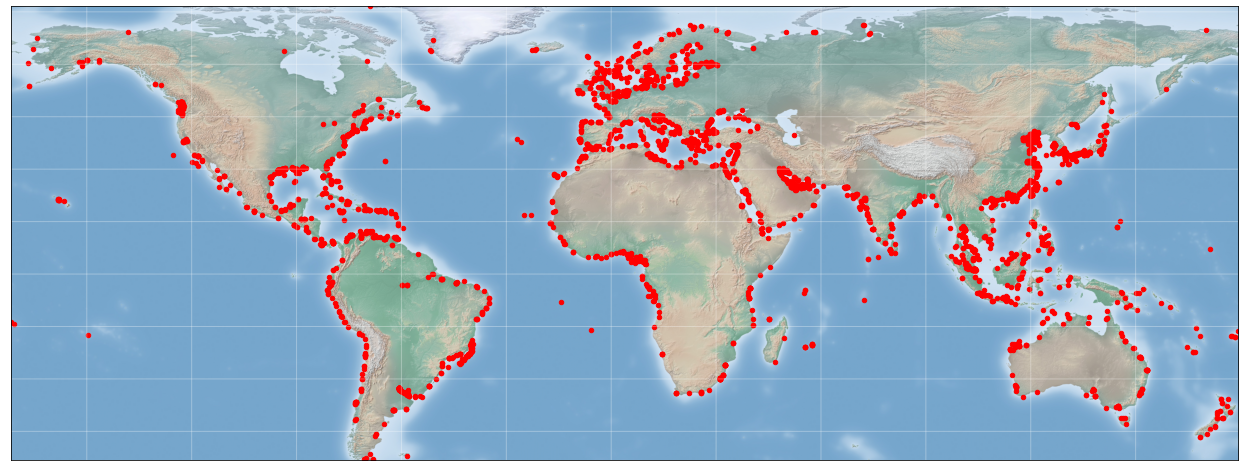

In [240]:
# visulize original ports 
bbox=(df_all.Lat.min(),df_all.Lat.max(),df_all.Lon.min(),df_all.Lon.max())                                                        
print ("The respective minimum and maximum latitude and longitude coordiates of ports are:",bbox)

fig,ax=plt.subplots(figsize=(22,14))
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=bbox[0], urcrnrlat=bbox[1],
            llcrnrlon=bbox[2], urcrnrlon=bbox[3])
ax.scatter(df_all.Lon,df_all.Lat,zorder=1, alpha= 1, c='r', s=20)
draw_map(m)

ax.set_xlim(bbox[2],bbox[3]);
ax.set_ylim(bbox[0],bbox[1]);
#fig.savefig("C:/posDoc-SDU-Denmark/SDU_research/shippingLabwp1/portsOriginal_1.png",dpi=400)

# Step e): Save dataset

In [249]:
df_all.to_csv("C:/posDoc-SDU-Denmark/SDU_research/shippingLabwp1/savedFile/portsInfo_1.csv",index=False)

In [131]:
df_gang=pd.ExcelFile("C:/posDoc-SDU-Denmark/SDU_research/shippingLabwp1/PortList.xlsx")
df_gang=df_gang.parse(header=0,index_col=0)
df_gang.head()

,Country,Terminal,Port Group,Region,Lat,Lon,num of calls
index,,,,,,,
6,Argentina,Rio Cullen,Rio Cullen,East Sou.Ame,-52.804410,-68.208910,56
13,Argentina,Punta Loyola,Rio Cullen,East Sou.Ame,-51.606985,-69.019225,14
17,New Zealand,Dunedin,Bluff,Oceania,-45.875160,170.519330,26
18,Argentina,Comodoro Rivadavia,Caleta Cordova,East Sou.Ame,-45.860180,-67.389045,40
19,Argentina,Caleta Cordova,Caleta Cordova,East Sou.Ame,-45.773050,-67.320400,447
